# This notebook is to test python plotting .mat TTC files



In [1]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from ttc_utils import *
from scipy.optimize import curve_fit
from importlib import reload


# Wrapper function for easily displaying markdown text
disp_md = lambda text: display(Markdown(text))

In [2]:
r2  = io.loadmat('TTC_data/RunData_Cornering/B2356run5.mat')

print(r2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AMBTMP', 'ET', 'FX', 'FY', 'FZ', 'IA', 'MX', 'MZ', 'N', 'NFX', 'NFY', 'P', 'RE', 'RL', 'RST', 'RUN', 'SA', 'SL', 'SR', 'TSTC', 'TSTI', 'TSTO', 'V', 'channel', 'source', 'testid', 'tireid'])


### Plot Full Run

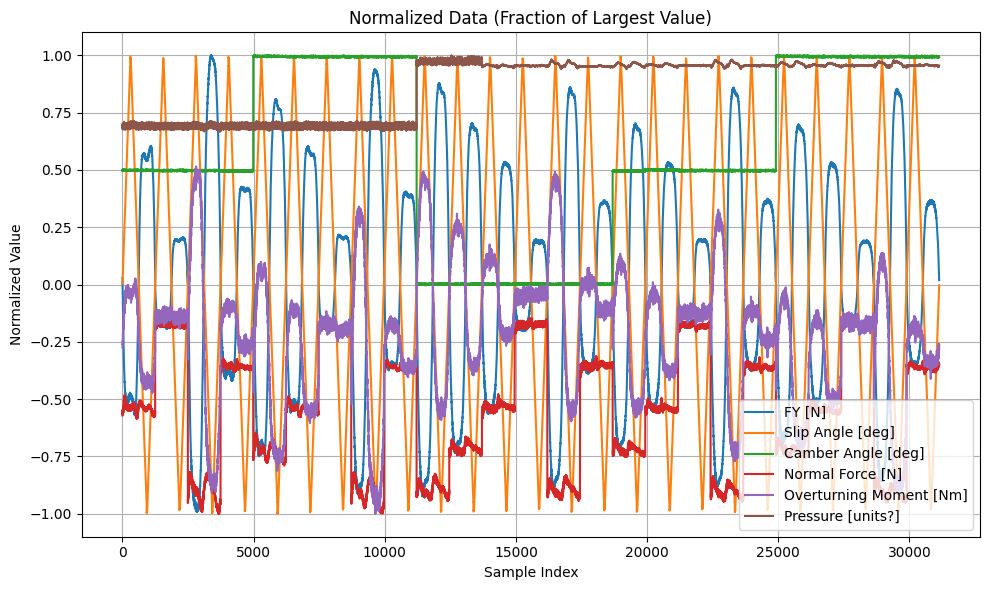

In [3]:
V = r2['V'].flatten()
SA = r2['SA'].flatten()
IA = r2['IA'].flatten()
FZ = r2['FZ'].flatten()
FY = r2['FY'].flatten()
MX = r2['MX'].flatten()
P = r2['P'].flatten()

# Normalize all data as a fraction of their respective maximum absolute value
V_norm = V / np.max(np.abs(V)) if np.max(np.abs(V)) != 0 else V
SA_norm = SA / np.max(np.abs(SA)) if np.max(np.abs(SA)) != 0 else SA
IA_norm = IA / np.max(np.abs(IA)) if np.max(np.abs(IA)) != 0 else IA
FZ_norm = FZ / np.max(np.abs(FZ)) if np.max(np.abs(FZ)) != 0 else FZ
FY_norm = FY / np.max(np.abs(FY)) if np.max(np.abs(FY)) != 0 else FY
MX_norm = MX / np.max(np.abs(MX)) if np.max(np.abs(MX)) != 0 else MX
P_norm = P / np.max(np.abs(P)) if np.max(np.abs(P)) != 0 else P



fig, ax = plt.subplots(figsize=(10,6))
ax.plot(FY_norm, label='FY [N]')
ax.plot(SA_norm, label='Slip Angle [deg]')
ax.plot(IA_norm, label='Camber Angle [deg]')
ax.plot(FZ_norm, label='Normal Force [N]')
ax.plot(MX_norm, label='Overturning Moment [Nm]')
ax.plot(P_norm, label='Pressure [units?]')



ax.set_title('Normalized Data (Fraction of Largest Value)')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Normalized Value')
ax.grid()
ax.legend()

fig.tight_layout()
plt.show()

### Fit MF6.1 lateral model

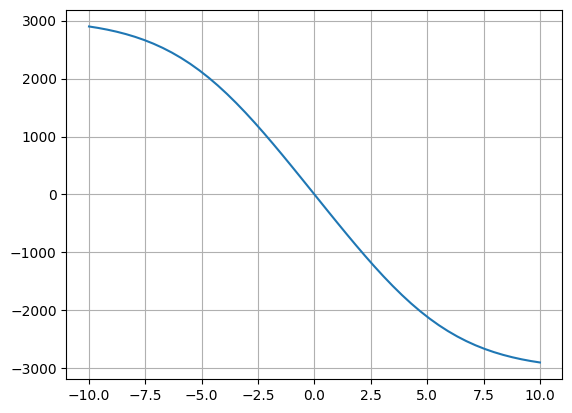

In [46]:
import magic_formula
reload(magic_formula)
mf61_Fy = magic_formula.mf61_Fy
#From Pacejka table A3.1
p_cy1 = 1.3

p_dy1 = 1
p_dy2 = 0
p_dy3 = 0

p_ey1 = -1
p_ey2 = 0
p_ey3 = 0
p_ey4 = 0
p_ey5 = 0 # ?? is this necessary 

p_ky1 = 10
p_ky2 = 1.5
p_ky3 = 0
p_ky4 = 2
p_ky5 = 0
p_ky6 = 2.5
p_ky7 = 0

p_hy1 = 0
p_hy2 = 0

p_vy1 = 0
p_vy2 = 0
p_vy3 = 0.15
p_vy4 = 0

p_py1 = -0.6255
p_py2 = -0.06523
p_py3 = -0.16666
p_py4 = 0.2811
p_py5 = 0


f_z0 = 3000
p_i0 = 220

p = [ p_cy1, p_dy1, p_dy2, p_dy3, p_ey1, p_ey2, p_ey3, p_ey4, p_ey5, p_ky1, p_ky2, p_ky3, p_ky4, p_ky5, p_ky6, p_ky7, p_hy1, p_hy2, p_vy1, p_vy2, p_vy3, p_vy4, p_py1, p_py2, p_py4, p_py5, p_i0, f_z0 ]


slip_range = np.linspace(-10, 10)

ia = 0
plt.plot(slip_range, mf61_Fy([slip_range, f_z0, ia, p_i0], p))
plt.grid()

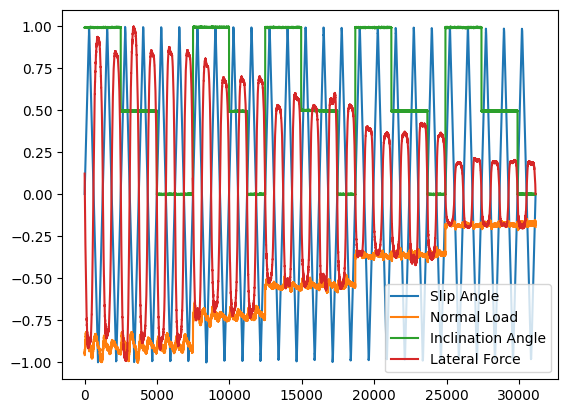

ValueError: too many values to unpack (expected 28)

In [ ]:
inclination_steps = regroup_similar_steps(process_stepwise_data(IA, extr_data=[FZ, SA, FY, P]), rel_tol=0.05)
ia, fz, sa, fy, p = np.concatenate([[ia, fz, sa, fy, p] for camber_avg, (ia, fz, sa, fy, p) in inclination_steps], axis=1)

fz_steps = regroup_similar_steps(process_stepwise_data(fz, extr_data = [ia, sa, fy, p]))
sa, fz, ia, fy, p = np.concatenate([[sa, fz, ia, fy, p] for camber_avg, (fz, ia, sa, fy, p) in fz_steps], axis=1)

#Plot data with transients removed 
plt.plot(sa/np.max(np.abs(sa)), label = 'Slip Angle')
plt.plot(fz/np.max(np.abs(fz)), label = 'Normal Load')
plt.plot(ia/np.max(np.abs(ia)), label = 'Inclination Angle')
plt.plot(fy/np.max(np.abs(fy)), label = 'Lateral Force')
plt.legend()
plt.show()

f_z0 = 700
p_i0 = np.average(p)

xdata = (sa, fz, ia, p)

# Use a wrapper function for curve_fit to avoid a huge lambda argument list
def mf61_fitfunc(x, *params):
    # params: all model parameters in order, then p_i0, f_z0 at the end
    return mf61_Fy(x, list(params) + [p_i0, f_z0])

# Number of model parameters (excluding p_i0, f_z0)
n_params = 27  # Adjust this to match mf61_Fy parameter count (excluding p_i0, f_z0)
p0 = [ p_cy1, p_dy1, p_dy2, p_dy3, p_ey1, p_ey2, p_ey3, p_ey4, p_ey5, p_ky1, p_ky2, p_ky3, p_ky4, p_ky5, p_ky6, p_ky7, p_hy1, p_hy2, p_vy1, p_vy2, p_vy3, p_vy4, p_py1, p_py2, p_py4, p_py5]

popt, pcov = curve_fit(mf61_fitfunc, xdata, fy, p0=p0, maxfev=500000)

popt = list(popt) + [p_i0, f_z0]

print(popt)

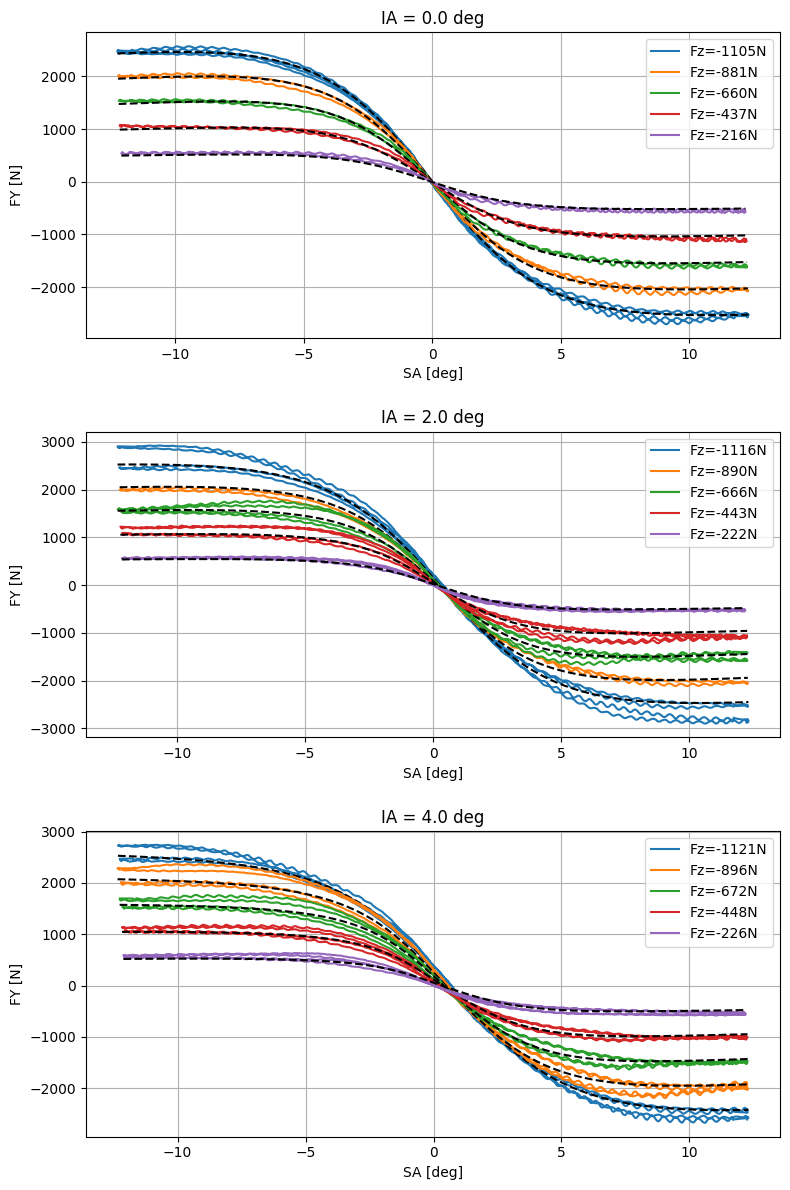

In [ ]:
fig, ax = plt.subplots(len(inclination_steps),1, figsize=(8, 12))
ax = ax.flatten()

for ax_i, c_step in zip(ax, inclination_steps):
    incl_avg, (ia, fz, sa, fy, p) = c_step

    fz_steps = regroup_similar_steps(process_stepwise_data(fz, extr_data = [sa, fy]))

    for step in fz_steps:
        fz_avg, (fz, sa, fy) = step
        ax_i.plot(sa, fy, label = f"Fz={fz_avg:.0f}N")
        
        # Plot fitted curve using matplotlib's plot
        sa_fit = np.linspace(np.min(sa), np.max(sa), 100)
        fy_fit = mf61_Fy((sa_fit, fz_avg, incl_avg, np.average(p)), list(popt))
        ax_i.plot(sa_fit, fy_fit, '--', color = 'black')

    ax_i.set_title(f'IA = {incl_avg:.1f} deg')
    ax_i.set_xlabel('SA [deg]')
    ax_i.set_ylabel('FY [N]')
    ax_i.grid()
    ax_i.legend()


fig.tight_layout(h_pad=2)
plt.show()